# DSCI 591 Data Analysis
## Covid-19

In [154]:
import os
import glob
import re

import scipy
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
import findspark
import numpy as np
from scipy.stats import pearsonr


from ipynb.fs.full.covid_data_collection import get_counties_df, get_county_stats_df

In [3]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 100)

### Initialize Spark

In [4]:
findspark.init() 

In [5]:
spark = SparkSession.builder.getOrCreate()

21/11/13 08:29:37 WARN Utils: Your hostname, noah-WS-Z390-PRO resolves to a loopback address: 127.0.1.1; using 10.0.0.58 instead (on interface eno1)
21/11/13 08:29:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/13 08:29:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Merge and reformat COVID data by date and FIPS

In [6]:
# FIPS codes from the FCC.  Attempt to match all counties


def make_lookup_functions():
    fcc_county_file = './config/fcc_county_fips.txt'
    with open(fcc_county_file) as fh:
        state = None
        fips_to_county = {}
        county_to_fips = {}
        for row in fh:
            if match := re.match(r'\s+(\d\d\d\d\d)\s+ (.*)', row):
                fips, location = match.groups()
                if fips.endswith('000'):
                    state = location.replace(' ','')
                    continue

                location = location.split(' County')[0]
                location = location.split(' Borough')[0]
                location = location.split(' Census Area')[0]
                location = location.split(' Parish')[0]
                location = location.split(' National Park')[0]
                
                if state == 'Florida' and location == 'Dade':
                    location = 'Miami-Dade'
                if state == 'Massachusetts' and location == 'Dukes':
                    location = 'DukesandNantucket'
                if state == 'Alaska' and location == 'Wrangell-Petersburg':
                    location = 'Wrangell'
                if state == 'Alaska' and location == 'Skagway-Hoonah-Angoon':
                    location = 'Skagway'
                if state == 'Alaska' and location == 'Prince of Wales-Outer Ketchikan':
                    location = 'Prince of Wales'
                if state == 'New York' and location == 'New York':
                    location = 'New York City'
                    
                try:
                    location = ''.join([s[0].upper() + s[1:] for s in location.split(' ')])    
                except:
                    pass  # garbage

                county = location.replace(' ', '') + '_' + state + '_UnitedStates'
                fips_to_county[int(fips)] = county
                county_to_fips[county.lower()] = int(fips)
                
        def lookup_county_from_fips(fips_):
            return fips_to_county[int(fips_)]
        
        def lookup_fips_from_county(county_):
            try:
                return county_to_fips[county_.lower()]
            except KeyError:
                pass
            
            try:
                county_ = county_.lower()
                parts = county_.split('_')
                parts[0] = parts[0][:parts[0].index('city')]
                return county_to_fips['_'.join(parts)]
            except:
                pass
            
            try:
                parts = county_.split('_')
                parts[0] = parts[0] +'city'
                return county_to_fips['_'.join(parts)]
            except:
                pass
    
            parts = county_.split('_')
            for k, v in county_to_fips.items():
                part0, part1, _ = k.split('_')
                if part1 != parts[1]:
                    continue
                if parts[0].startswith(part0) or part0.startswith(parts[0]):
                    return v

            raise KeyError
                
        
        return lookup_county_from_fips, lookup_fips_from_county

get_county_from_fips,  get_fips_from_county = make_lookup_functions()

In [177]:
def merge_processed_data() -> ps.DataFrame:
    path = './processed_data/county_merged_parts/*.pkl'
    sdf = None
    error_count = 0
    total_length = 0
    for file in glob.glob(path):
        county = re.search(r'merged_parts.(.*)\.pkl', file).groups(1)[0]

        df = pd.read_pickle(file)
 
        try:
            df.reset_index(inplace=True)
            df.sort_values('dates', inplace=True)
            

            df['fips'] = get_fips_from_county(county)
            df['county'] = county
            df['Date Local'] = df.dates.to_list()
            
            # Turn cummulatives into daily deltas
            
            df['jhu_daily_death'] = df['JHU_ConfirmedDeaths.data'].diff()
            df['jhu_daily_cases'] = df['JHU_ConfirmedCases.data'].diff()
            
            # Generate rolling averages
            rolling = df.rolling(7, on='dates' ).mean()
            df['jhu_daily_death_rolling_7'] = rolling.jhu_daily_death
            df['jhu_daily_cases_rolling_7'] = rolling.jhu_daily_cases
            
            rolling = df.rolling(30, on='dates' ).mean()
            df['jhu_daily_death_rolling_30'] = rolling.jhu_daily_death
            df['jhu_daily_cases_rolling_30'] = rolling.jhu_daily_cases
            
            if sdf is not None:
                sdf = sdf.append(df, ignore_index=True)
            else:
                sdf = df


        except KeyError:
            if not county.startswith('Unassigned') and not county.startswith('Outof'):
                print(f'Key Error {county}')
                
    
    sdf.drop(columns=['LND110210'], inplace=True)
    county_pop_df = get_county_stats_df()
    sdf = sdf.merge(county_pop_df, how='inner', on='fips')
        
    return sdf
    
    
sdf = merge_processed_data()



Key Error KansasCity_Missouri_UnitedStates
Key Error Hoonah-Angoon_Alaska_UnitedStates


In [178]:
sdf

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Excess_Deaths.data,NYT_AllCausesDeathsMonthly_Excess_Deaths.missing,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.missing,TotalPopulation.data,TotalPopulation.missing,MaleAndFemale_AtLeast65_Population.data,MaleAndFemale_AtLeast65_Population.missing,Male_Total_Population.data,Male_Total_Population.missing,Female_Total_Population.data,Female_Total_Population.missing,MaleAndFemale_Under18_Population.data,MaleAndFemale_Under18_Population.missing,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,county,Date Local,jhu_daily_death,jhu_daily_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,LND110210
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.414340,0,2489.5,0,34.687500,0.0,26.677083,0.0,73.010417,0.0,28.023021,0.0,0.000000,0.0,0.0,0.0,190.208333,0.0,6.510417,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,575.16
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.414340,0,2489.5,0,35.359375,0.0,31.307292,0.0,85.817708,0.0,28.087865,0.0,0.000000,0.0,0.0,0.0,207.031250,0.0,5.322917,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-02,0.0,0.0,NaN,NaN,NaN,NaN,575.16
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.414340,0,2489.5,0,32.729167,0.0,25.322917,0.0,75.854167,0.0,28.425521,0.0,0.000000,0.0,0.0,0.0,266.875000,0.0,8.593750,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-03,0.0,0.0,NaN,NaN,NaN,NaN,575.16
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.414340,0,2489.5,0,33.541667,0.0,23.421875,0.0,67.760417,0.0,28.559948,0.0,0.000000,0.0,0.0,0.0,198.750000,0.0,8.359375,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-04,0.0,0.0,NaN,NaN,NaN,NaN,575.16
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.414340,0,2489.5,0,38.833333,0.0,25.718750,0.0,62.000000,0.0,28.635312,0.

In [179]:
def pickle_sdf(sdf):
    sdf.to_pickle('./processed_data/merged_eda/sdf.pkl')
    
def load_sdf():
    return pd.read_pickle('./processed_data/merged_eda/sdf.pkl')

pickle_sdf(sdf)

In [52]:
# To save time

sdf = load_sdf()

In [123]:
sdf.head()

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Excess_Deaths.data,NYT_AllCausesDeathsMonthly_Excess_Deaths.missing,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.missing,TotalPopulation.data,TotalPopulation.missing,MaleAndFemale_AtLeast65_Population.data,MaleAndFemale_AtLeast65_Population.missing,Male_Total_Population.data,Male_Total_Population.missing,Female_Total_Population.data,Female_Total_Population.missing,MaleAndFemale_Under18_Population.data,MaleAndFemale_Under18_Population.missing,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,county,Date Local,jhu_daily_death,jhu_daily_cases,LND110210
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.41434,0,2489.5,0,34.687500,0.0,26.677083,0.0,73.010417,0.0,28.023021,0.0,0.0,0.0,0.0,0.0,190.208333,0.0,6.510417,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-01,NaN,NaN,575.16
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.41434,0,2489.5,0,35.359375,0.0,31.307292,0.0,85.817708,0.0,28.087865,0.0,0.0,0.0,0.0,0.0,207.031250,0.0,5.322917,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-02,0.0,0.0,575.16
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.41434,0,2489.5,0,32.729167,0.0,25.322917,0.0,75.854167,0.0,28.425521,0.0,0.0,0.0,0.0,0.0,266.875000,0.0,8.593750,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-03,0.0,0.0,575.16
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.41434,0,2489.5,0,33.541667,0.0,23.421875,0.0,67.760417,0.0,28.559948,0.0,0.0,0.0,0.0,0.0,198.750000,0.0,8.359375,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-04,0.0,0.0,575.16
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,4148.0,0.0,1137.0,0.0,2085.0,0.0,2110.0,0.0,838.0,0.0,2404.5,0,85.0,0,3.41434,0,2489.5,0,38.833333,0.0,25.718750,0.0,62.000000,0.0,28.635312,0.0,0.0,0.0,0.0,0.0,247.291667,0.0,8.020833,0.0,NaN,NaN,NaN,4148.0,31129,Nuckolls_Nebraska_UnitedStates,2020-01-05,0.0,0.0,575.16


### EDA on Covid Data Set

##### Filter and create rollups

###### Filter to one year period 2020-03-11 to 2021-03-11

2020-03-11 is the unofficial start of the pandemic in the US
2021-03-11 is one year later.  At this point, most of the US population was not eligible for vaccines

In [180]:
sdf_filtered = sdf.copy()
sdf_filtered = sdf_filtered[sdf_filtered.dates >= '2020-03-11']
sdf_filtered = sdf_filtered[sdf_filtered.dates <= '2021-03-11']

###### Add derived fields based on the source data
This includes normalizing the raw count data into percent of population 

In [181]:
sdf_filtered['jhu_death_rate'] = sdf_filtered['jhu_daily_death_rolling_30']/sdf_filtered['latestTotalPopulation']
sdf_filtered['jhu_case_rate'] = sdf_filtered['jhu_daily_cases_rolling_30']/sdf_filtered['latestTotalPopulation']
sdf_filtered['density'] = sdf_filtered['latestTotalPopulation']/sdf_filtered['LND110210']
sdf_filtered['icu_beds_per_person'] = sdf_filtered['hospitalIcuBeds']/sdf_filtered['latestTotalPopulation']
sdf_filtered['staffed_beds_per_person'] = sdf_filtered['hospitalStaffedBeds']/sdf_filtered['latestTotalPopulation']
sdf_filtered['licensed_beds_per_person'] = sdf_filtered['hospitalLicensedBeds']/sdf_filtered['latestTotalPopulation']
sdf_filtered['cold_days'] = [1 if t < 50 else 0 for t in sdf_filtered['AverageDailyTemperature.data']]
sdf_filtered['hot_days'] = [1 if t > 90 else 0 for t in sdf_filtered['AverageDailyTemperature.data']]
sdf_filtered['moderate_days'] = [1 if t >= 50 and t <=90 else 0 for t in sdf_filtered['AverageDailyTemperature.data']]
sdf_filtered['gte_65_percent'] = sdf_filtered['MaleAndFemale_AtLeast65_Population.data']/sdf_filtered['latestTotalPopulation']
sdf_filtered['lt_18_percent'] = sdf_filtered['MaleAndFemale_Under18_Population.data']/sdf_filtered['latestTotalPopulation']
sdf_filtered['employed_percent'] = sdf_filtered['BLS_EmployedPopulation.data']/sdf_filtered['BLS_LaborForcePopulation.data']
sdf_filtered['unemployed_percent'] = sdf_filtered['BLS_UnemployedPopulation.data']/sdf_filtered['BLS_LaborForcePopulation.data']

sdf_filtered.drop(columns=['JHU_ConfirmedCases.data', 'JHU_ConfirmedCases.missing',
       'NYT_ConfirmedCases.data', 'NYT_ConfirmedCases.missing',
       'JHU_ConfirmedDeaths.data', 'JHU_ConfirmedDeaths.missing',
       'JHU_ConfirmedRecoveries.data', 'JHU_ConfirmedRecoveries.missing',
       'NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing',
       'NYT_ConfirmedDeaths.data', 'NYT_ConfirmedDeaths.missing',
       'NYT_AllCausesDeathsWeekly_Excess_Deaths.data',
       'NYT_AllCausesDeathsWeekly_Excess_Deaths.missing',
       'NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing',
       'NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing',
       'NYT_AllCausesDeathsMonthly_Excess_Deaths.data',
       'NYT_AllCausesDeathsMonthly_Excess_Deaths.missing',
       'NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.data',
       'NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.missing',
       'TotalPopulation.data', 'TotalPopulation.missing',
       'MaleAndFemale_AtLeast65_Population.data',
       'MaleAndFemale_AtLeast65_Population.missing',
       'Male_Total_Population.data', 'Male_Total_Population.missing',
       'Female_Total_Population.data', 'Female_Total_Population.missing',
       'MaleAndFemale_Under18_Population.data',
       'MaleAndFemale_Under18_Population.missing',
       'BLS_EmployedPopulation.data', 'BLS_EmployedPopulation.missing',
       'BLS_UnemployedPopulation.data', 'BLS_UnemployedPopulation.missing',
       'BLS_UnemploymentRate.data', 'BLS_UnemploymentRate.missing',
       'BLS_LaborForcePopulation.data', 'BLS_LaborForcePopulation.missing',
       'AverageDailyTemperature.data', 'AverageDailyTemperature.missing',
       'AverageDewPoint.data', 'AverageDewPoint.missing',
       'AverageRelativeHumidity.data', 'AverageRelativeHumidity.missing',
       'AverageSurfaceAirPressure.data', 'AverageSurfaceAirPressure.missing',
       'AveragePrecipitationTotal.data', 'AveragePrecipitationTotal.missing',
       'AveragePrecipitation.data', 'AveragePrecipitation.missing',
       'AverageWindDirection.data', 'AverageWindDirection.missing',
       'AverageWindSpeed.data', 'AverageWindSpeed.missing', 'hospitalIcuBeds',
       'hospitalStaffedBeds', 'hospitalLicensedBeds', 'latestTotalPopulation',
       'LND110210', 'jhu_daily_death','jhu_daily_cases', 'jhu_daily_death_rolling_7','jhu_daily_cases_rolling_7', 
                           'jhu_daily_death_rolling_30','jhu_daily_cases_rolling_30'],  inplace=True)

sdf_filtered = sdf_filtered.fillna(0)

sdf_filtered.head()

,dates,fips,county,Date Local,jhu_death_rate,jhu_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
70,2020-03-11,31129,Nuckolls_Nebraska_UnitedStates,2020-03-11,0.0,0.0,7.211906,0.0,0.0,0.0,1,0,0,0.274108,0.202025,0.961177,0.038823
71,2020-03-12,31129,Nuckolls_Nebraska_UnitedStates,2020-03-12,0.0,0.0,7.211906,0.0,0.0,0.0,0,0,1,0.274108,0.202025,0.961177,0.038823
72,2020-03-13,31129,Nuckolls_Nebraska_UnitedStates,2020-03-13,0.0,0.0,7.211906,0.0,0.0,0.0,1,0,0,0.274108,0.202025,0.961177,0.038823
73,2020-03-14,31129,Nuckolls_Nebraska_UnitedStates,2020-03-14,0.0,0.0,7.211906,0.0,0.0,0.0,1,0,0,0.274108,0.202025,0.961177,0.038823
74,2020-03-15,31129,Nuckolls_Nebraska_UnitedStates,2020-03-15,0.0,0.0,7.211906,0.0,0.0,0.0,1,0,0,0.274108,0.202025,0.961177,0.038823


##### Roll up all dates for period

In [182]:
rollup_by_county = sdf_filtered.groupby(by='county').agg({'jhu_death_rate': 'sum',
                                                            'jhu_case_rate': 'sum',
                                                            'cold_days': 'sum',
                                                            'hot_days': 'sum',
                                                            'moderate_days': 'sum',
                                                            'density': 'max',
                                                            'icu_beds_per_person': 'mean',
                                                            'staffed_beds_per_person': 'mean',
                                                            'licensed_beds_per_person': 'mean',
                                                            'gte_65_percent': 'mean',
                                                            'lt_18_percent': 'mean',
                                                            'employed_percent': 'mean',
                                                            'unemployed_percent': 'mean'})

rollup_by_date = sdf_filtered.groupby(by='dates').agg({'jhu_death_rate': 'sum',
                                                            'jhu_case_rate': 'sum',
                                                            'cold_days': 'sum',
                                                            'hot_days': 'sum',
                                                            'moderate_days': 'sum',
                                                            'density': 'sum',
                                                            'icu_beds_per_person': 'sum',
                                                            'staffed_beds_per_person': 'sum',
                                                            'licensed_beds_per_person': 'sum',
                                                            'gte_65_percent': 'sum',
                                                            'lt_18_percent': 'sum',
                                                            'employed_percent': 'sum',
                                                            'unemployed_percent': 'sum'})


In [183]:
rollup_by_county.corr()

,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,1.000000,0.685549,-0.175143,0.059230,0.168885,0.011473,0.121733,0.104507,0.090338,0.078629,0.163503,0.017900,-0.001088
jhu_case_rate,0.685549,1.000000,-0.069156,0.033133,0.064589,-0.019437,0.054486,0.059102,0.055622,-0.102979,0.196309,0.038963,-0.071080
cold_days,-0.175143,-0.069156,1.000000,-0.191414,-0.985749,-0.029772,0.009207,-0.023459,-0.037922,0.122565,-0.037173,0.090221,-0.124076
hot_days,0.059230,0.033133,-0.191414,1.000000,0.067429,-0.013665,-0.016620,-0.020683,-0.024110,-0.021723,0.067703,-0.017448,0.109362
moderate_days,0.168885,0.064589,-0.985749,0.067429,1.000000,0.032258,-0.006994,0.026987,0.042065,-0.121231,0.028804,-0.089331,0.111133
density,0.011473,-0.019437,-0.029772,-0.013665,0.032258,1.000000,0.012774,0.039808,0.036522,-0.151168,-0.011217,-0.046649,0.175697
icu_beds_per_person,0.121733,0.054486,0.009207,-0.016620,-0.006994,0.012774,1.000000,0.836502,0.761960,0.005381,0.095844,0.041519,-0.076902
staffed_beds_per_person,0.104507,0.059102,-0.023459,-0.020683,0.026987,0.039808,0.836502,1.000000,0.903833,-0.059235,0.064448,0.009995,-0.002229
licensed_beds_per_person,0.090338,0.055622,-0.037922,-0.024110,0.042065,0.036522,0.761960,0.903833,1.000000,-0.069291,0.063131,0.009021,0.013247
gte_65_percent,0.078629,-0.102979,0.122565,-0.021723,-0.121231,-0.151168,0.005381,-0.059235,-0.069291,1.000000,-0.393634,0.100792,-0.062470


In [184]:
# p values
rollup_by_county.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(rollup_by_county.columns)) 

,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000e+00,0.000000e+00,5.381958e-23,9.119339e-04,1.796744e-21,5.209906e-01,8.177371e-12,4.563235e-09,4.104080e-07,1.055503e-05,3.300918e-20,3.166037e-01,9.514719e-01
jhu_case_rate,0.000000e+00,0.000000e+00,1.073459e-04,6.373210e-02,2.980530e-04,2.768415e-01,2.285842e-03,9.357481e-04,1.845757e-03,7.640256e-09,1.403429e-28,2.921908e-02,6.851641e-05
cold_days,5.381958e-23,1.073459e-04,0.000000e+00,3.148552e-27,0.000000e+00,9.574231e-02,6.065083e-01,1.893461e-01,3.382213e-02,5.880724e-12,3.750203e-02,4.248758e-07,3.214936e-12
hot_days,9.119339e-04,6.373210e-02,3.148552e-27,0.000000e+00,1.591074e-04,4.445665e-01,3.524687e-01,2.471985e-01,1.773568e-01,2.242224e-01,1.495616e-04,3.289919e-01,8.444860e-10
moderate_days,1.796744e-21,2.980530e-04,0.000000e+00,1.591074e-04,0.000000e+00,7.106911e-02,6.956146e-01,1.310554e-01,1.856087e-02,9.964616e-12,1.070348e-01,5.518810e-07,4.480335e-10
density,5.209906e-01,2.768415e-01,9.574231e-02,4.445665e-01,7.106911e-02,0.000000e+00,4.748466e-01,2.589292e-02,4.097179e-02,1.807468e-17,5.303144e-01,9.026790e-03,3.920963e-23
icu_beds_per_person,8.177371e-12,2.285842e-03,6.065083e-01,3.524687e-01,6.956146e-01,4.748466e-01,0.000000e+00,0.000000e+00,0.000000e+00,7.634132e-01,7.697797e-08,2.014370e-02,1.644389e-05
staffed_beds_per_person,4.563235e-09,9.357481e-04,1.893461e-01,2.471985e-01,1.310554e-01,2.589292e-02,0.000000e+00,0.000000e+00,0.000000e+00,9.111130e-04,3.072606e-04,5.760587e-01,9.007697e-01
licensed_beds_per_person,4.104080e-07,1.845757e-03,3.382213e-02,1.773568e-01,1.856087e-02,4.097179e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.040647e-04,4.075107e-04,6.137981e-01,4.586332e-01
gte_65_percent,1.055503e-05,7.640256e-09,5.880724e-12,2.242224e-01,9.964616e-12,1.807468e-17,7.634132e-01,9.111130e-04,1.040647e-04,0.000000e+00,1.352021e-116,1.577749e-08,4.685982e-04


In [185]:
rollup_by_date.corr()

,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,1.000000,0.926496,0.783430,-0.238167,-0.784674,NaN,NaN,NaN,NaN,NaN,NaN,0.475143,-0.475143
jhu_case_rate,0.926496,1.000000,0.743979,-0.204305,-0.745550,NaN,NaN,NaN,NaN,NaN,NaN,0.528857,-0.528857
cold_days,0.783430,0.743979,1.000000,-0.400513,-0.999867,NaN,NaN,NaN,NaN,NaN,NaN,0.347541,-0.347541
hot_days,-0.238167,-0.204305,-0.400513,1.000000,0.385490,NaN,NaN,NaN,NaN,NaN,NaN,-0.032552,0.032552
moderate_days,-0.784674,-0.745550,-0.999867,0.385490,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.349396,0.349396
density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
icu_beds_per_person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
staffed_beds_per_person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
licensed_beds_per_person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gte_65_percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
quarters = [('2020-03-11', '2020-06-11'), ('2020-06-11','2020-09-11'), ('2020-09-11','2020-12-11'),
               ('2020-12-11','2021-03-11')]
filtered_quarters = []
rollup_by_counties = []
corr_by_county_rollup = []
corr_by_county_rollup_pvalues = []
rollup_by_dates = []
corr_by_date_rollup = []
corr_by_date_rollup_pvalues = []

for quarter in quarters:
    fq = sdf_filtered[sdf_filtered.dates >= quarter[0]]
    fq = fq[fq.dates < quarter[1]]
    filtered_quarters.append(fq)
    rbc = fq.groupby(by='county').agg({'jhu_death_rate': 'sum',
                                        'jhu_case_rate': 'sum',
                                        'cold_days': 'sum',
                                        'hot_days': 'sum',
                                        'moderate_days': 'sum',
                                        'density': 'max',
                                        'icu_beds_per_person': 'mean',
                                        'staffed_beds_per_person': 'mean',
                                        'licensed_beds_per_person': 'mean',
                                        'gte_65_percent': 'mean',
                                        'lt_18_percent': 'mean',
                                        'employed_percent': 'mean',
                                        'unemployed_percent': 'mean'})
    rollup_by_counties.append(rbc)
    corr_by_county_rollup.append(rbc.corr(method=lambda x, y: pearsonr(x, y)[0]) - np.eye(len(rbc.columns)))
    corr_by_county_rollup_pvalues.append(rbc.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(rbc.columns))) 
    rbd = fq.groupby(by='dates').agg({'jhu_death_rate': 'sum',
                                        'jhu_case_rate': 'sum',
                                        'cold_days': 'sum',
                                        'hot_days': 'sum',
                                        'moderate_days': 'sum',
                                        'density': 'sum',
                                        'icu_beds_per_person': 'sum',
                                        'staffed_beds_per_person': 'sum',
                                        'licensed_beds_per_person': 'sum',
                                        'gte_65_percent': 'sum',
                                        'lt_18_percent': 'sum',
                                        'employed_percent': 'sum',
                                        'unemployed_percent': 'sum'})
    rollup_by_dates.append(rbd)
    corr_by_date_rollup.append(rbd.corr())
    
    

In [188]:
for i, (r, p) in enumerate(zip(corr_by_county_rollup, corr_by_county_rollup_pvalues)):
    print(f'Quarter {i}')
    print('Pearson Correlation')
    display(r)
    print('Pearson p value')
    display(p)

Quarter 0
Pearson Correlation


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000,0.789249,-0.047245,-0.010967,0.048108,0.160918,-0.005373,0.019629,0.013221,-0.093818,0.031918,-0.083081,0.074077
jhu_case_rate,0.789249,0.000000,-0.029386,-0.005341,0.029948,0.053514,-0.001120,0.012091,0.008550,-0.126173,0.075875,-0.020390,0.001596
cold_days,-0.047245,-0.029386,0.000000,-0.071575,-0.996480,-0.003964,-0.001984,-0.023553,-0.038019,0.121620,-0.088893,-0.018038,0.114189
hot_days,-0.010967,-0.005341,-0.071575,0.000000,0.035734,-0.005812,-0.009631,-0.008750,-0.012167,-0.010713,0.048329,-0.016215,0.060798
moderate_days,0.048108,0.029948,-0.996480,0.035734,0.000000,0.004378,0.002490,0.024249,0.038825,-0.121057,0.087009,0.018778,-0.117208
density,0.160918,0.053514,-0.003964,-0.005812,0.004378,0.000000,0.012774,0.039808,0.036522,-0.151168,-0.011217,-0.041743,0.107841
icu_beds_per_person,-0.005373,-0.001120,-0.001984,-0.009631,0.002490,0.012774,0.000000,0.836502,0.761960,0.005381,0.095844,0.058437,-0.098278
staffed_beds_per_person,0.019629,0.012091,-0.023553,-0.008750,0.024249,0.039808,0.836502,0.000000,0.903833,-0.059235,0.064448,0.018118,-0.023307
licensed_beds_per_person,0.013221,0.008550,-0.038019,-0.012167,0.038825,0.036522,0.761960,0.903833,0.000000,-0.069291,0.063131,0.016069,-0.009924
gte_65_percent,-0.093818,-0.126173,0.121620,-0.010713,-0.121057,-0.151168,0.005381,-0.059235,-0.069291,0.000000,-0.393634,0.090547,-0.018554


Pearson p value


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000e+00,0.000000e+00,8.182655e-03,0.539541,7.084766e-03,1.290848e-19,7.637262e-01,0.272112,0.459514,1.440684e-07,7.409866e-02,3.227578e-06,3.329306e-05
jhu_case_rate,0.000000e+00,0.000000e+00,1.001178e-01,0.765092,9.379552e-02,2.737167e-03,9.500387e-01,0.498777,0.632419,1.373399e-12,2.130755e-05,2.539654e-01,9.288689e-01
cold_days,8.182655e-03,1.001178e-01,0.000000e+00,0.000061,0.000000e+00,8.245209e-01,9.116056e-01,0.187574,0.033368,8.549104e-12,6.269359e-07,3.129009e-01,1.465598e-10
hot_days,5.395410e-01,7.650923e-01,6.092743e-05,0.000000,4.553350e-02,7.450626e-01,5.900351e-01,0.624476,0.496064,5.489432e-01,6.826096e-03,3.643196e-01,6.632548e-04
moderate_days,7.084766e-03,9.379552e-02,0.000000e+00,0.045534,0.000000e+00,8.065305e-01,8.891976e-01,0.174860,0.029798,1.066895e-11,1.078737e-06,2.934601e-01,4.718819e-11
density,1.290848e-19,2.737167e-03,8.245209e-01,0.745063,8.065305e-01,0.000000e+00,4.748466e-01,0.025893,0.040972,1.807468e-17,5.303144e-01,1.947970e-02,1.444156e-09
icu_beds_per_person,7.637262e-01,9.500387e-01,9.116056e-01,0.590035,8.891976e-01,4.748466e-01,0.000000e+00,0.000000,0.000000,7.634132e-01,7.697797e-08,1.068303e-03,3.564266e-08
staffed_beds_per_person,2.721124e-01,4.987766e-01,1.875739e-01,0.624476,1.748600e-01,2.589292e-02,0.000000e+00,0.000000,0.000000,9.111130e-04,3.072606e-04,3.107586e-01,1.922233e-01
licensed_beds_per_person,4.595136e-01,6.324190e-01,3.336789e-02,0.496064,2.979841e-02,4.097179e-02,0.000000e+00,0.000000,0.000000,1.040647e-04,4.075107e-04,3.686597e-01,5.787627e-01
gte_65_percent,1.440684e-07,1.373399e-12,8.549104e-12,0.548943,1.066895e-11,1.807468e-17,7.634132e-01,0.000911,0.000104,0.000000e+00,1.352021e-116,3.858901e-07,2.992521e-01


Quarter 1
Pearson Correlation


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000,0.687517,-0.067454,0.100786,-0.005643,0.008571,0.047580,0.084608,0.079718,-0.104236,0.142495,-0.072759,0.203548
jhu_case_rate,0.687517,0.000000,-0.051721,0.095092,-0.019699,-0.002858,0.030055,0.074858,0.090472,-0.214362,0.198762,-0.065459,0.126106
cold_days,-0.067454,-0.051721,0.000000,-0.012695,-0.789071,-0.024795,-0.010619,-0.020697,-0.018607,-0.068189,0.071053,0.026107,-0.055498
hot_days,0.100786,0.095092,-0.012695,0.000000,-0.575512,-0.015934,-0.012002,-0.017608,-0.021519,-0.027579,0.082496,-0.025154,0.130769
moderate_days,-0.005643,-0.019699,-0.789071,-0.575512,0.000000,0.029601,0.015887,0.027711,0.028279,0.071180,-0.105516,-0.005976,-0.033902
density,0.008571,-0.002858,-0.024795,-0.015934,0.029601,0.000000,0.012774,0.039808,0.036522,-0.151168,-0.011217,-0.066784,0.225479
icu_beds_per_person,0.047580,0.030055,-0.010619,-0.012002,0.015887,0.012774,0.000000,0.836502,0.761960,0.005381,0.095844,0.038821,-0.059660
staffed_beds_per_person,0.084608,0.074858,-0.020697,-0.017608,0.027711,0.039808,0.836502,0.000000,0.903833,-0.059235,0.064448,0.003046,0.021639
licensed_beds_per_person,0.079718,0.090472,-0.018607,-0.021519,0.028279,0.036522,0.761960,0.903833,0.000000,-0.069291,0.063131,0.000675,0.040150
gte_65_percent,-0.104236,-0.214362,-0.068189,-0.027579,0.071180,-0.151168,0.005381,-0.059235,-0.069291,0.000000,-0.393634,0.119097,-0.119951


Pearson p value


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000e+00,0.000000e+00,0.000158,1.580684e-08,7.522634e-01,6.315749e-01,7.739963e-03,0.000002,7.942950e-06,5.002457e-09,1.125352e-15,4.587834e-05,1.208495e-30
jhu_case_rate,0.000000e+00,0.000000e+00,0.003788,9.729470e-08,2.704136e-01,8.729591e-01,9.262414e-02,0.000027,3.945220e-07,7.052212e-34,2.860460e-29,2.465511e-04,1.411832e-12
cold_days,1.582227e-04,3.787770e-03,0.000000,4.775615e-01,0.000000e+00,1.653456e-01,5.524565e-01,0.246883,2.978753e-01,1.339548e-04,6.894661e-05,1.440861e-01,1.889578e-03
hot_days,1.580684e-08,9.729470e-08,0.477561,0.000000e+00,9.292865e-276,3.726873e-01,5.019436e-01,0.324572,2.286032e-01,1.227962e-01,3.784549e-06,1.593206e-01,2.026479e-13
moderate_days,7.522634e-01,2.704136e-01,0.000000,9.292865e-276,0.000000e+00,9.766021e-02,3.741011e-01,0.121023,1.135867e-01,6.690895e-05,3.233334e-09,7.381377e-01,5.781588e-02
density,6.315749e-01,8.729591e-01,0.165346,3.726873e-01,9.766021e-02,0.000000e+00,4.748466e-01,0.025893,4.097179e-02,1.807468e-17,5.303144e-01,1.838860e-04,2.158737e-37
icu_beds_per_person,7.739963e-03,9.262414e-02,0.552457,5.019436e-01,3.741011e-01,4.748466e-01,0.000000e+00,0.000000,0.000000e+00,7.634132e-01,7.697797e-08,2.981694e-02,8.363860e-04
staffed_beds_per_person,2.120007e-06,2.745840e-05,0.246883,3.245719e-01,1.210229e-01,2.589292e-02,0.000000e+00,0.000000,0.000000e+00,9.111130e-04,3.072606e-04,8.646942e-01,2.260275e-01
licensed_beds_per_person,7.942950e-06,3.945220e-07,0.297875,2.286032e-01,1.135867e-01,4.097179e-02,0.000000e+00,0.000000,0.000000e+00,1.040647e-04,4.075107e-04,9.698691e-01,2.464305e-02
gte_65_percent,5.002457e-09,7.052212e-34,0.000134,1.227962e-01,6.690895e-05,1.807468e-17,7.634132e-01,0.000911,1.040647e-04,0.000000e+00,1.352021e-116,2.288231e-11,1.643462e-11


Quarter 2
Pearson Correlation


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000,0.479791,0.009313,-0.011183,-0.009565,0.012907,0.132499,0.087612,0.065855,0.102549,0.137448,0.045690,-0.052143
jhu_case_rate,0.479791,0.000000,0.338485,-0.014264,-0.337598,-0.073390,0.122120,0.081859,0.061755,0.006404,0.229991,0.107437,-0.304394
cold_days,0.009313,0.338485,0.000000,-0.061200,-0.991568,-0.072479,0.017936,-0.030323,-0.045690,0.147214,-0.001776,0.124032,-0.307502
hot_days,-0.011183,-0.014264,-0.061200,0.000000,-0.036055,-0.004409,-0.014816,-0.015377,-0.016522,0.001875,0.008831,-0.007922,0.044069
moderate_days,-0.009565,-0.337598,-0.991568,-0.036055,0.000000,0.073160,-0.016320,0.032242,0.047698,-0.147139,0.000678,-0.123279,0.302497
density,0.012907,-0.073390,-0.072479,-0.004409,0.073160,0.000000,0.012774,0.039808,0.036522,-0.151168,-0.011217,-0.043519,0.192389
icu_beds_per_person,0.132499,0.122120,0.017936,-0.014816,-0.016320,0.012774,0.000000,0.836502,0.761960,0.005381,0.095844,0.032650,-0.051124
staffed_beds_per_person,0.087612,0.081859,-0.030323,-0.015377,0.032242,0.039808,0.836502,0.000000,0.903833,-0.059235,0.064448,0.006419,0.013181
licensed_beds_per_person,0.065855,0.061755,-0.045690,-0.016522,0.047698,0.036522,0.761960,0.903833,0.000000,-0.069291,0.063131,0.006366,0.027089
gte_65_percent,0.102549,0.006404,0.147214,0.001875,-0.147139,-0.151168,0.005381,-0.059235,-0.069291,0.000000,-0.393634,0.107446,-0.106752


Pearson p value


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000e+00,4.516844e-180,6.023524e-01,0.531566,5.925662e-01,4.702447e-01,9.687167e-14,9.077472e-07,0.000226,8.820168e-09,1.111576e-14,1.054745e-02,3.511684e-03
jhu_case_rate,4.516844e-180,0.000000e+00,8.289784e-85,0.424866,2.395750e-84,3.937679e-05,7.015853e-12,4.494964e-06,0.000544,7.201325e-01,7.116656e-39,1.663014e-09,3.825779e-68
cold_days,6.023524e-01,8.289784e-85,0.000000e+00,0.000611,0.000000e+00,4.908328e-05,3.156511e-01,8.975397e-02,0.010548,1.225756e-16,9.208361e-01,3.272217e-12,1.419269e-69
hot_days,5.315657e-01,4.248657e-01,6.105825e-04,0.000000,4.363018e-02,8.051883e-01,4.071722e-01,3.896505e-01,0.355298,9.164617e-01,6.212773e-01,6.576327e-01,1.364379e-02
moderate_days,5.925662e-01,2.395750e-84,0.000000e+00,0.043630,0.000000e+00,4.163410e-05,3.612211e-01,7.121173e-02,0.007588,1.270081e-16,9.697421e-01,4.425027e-12,2.800523e-67
density,4.702447e-01,3.937679e-05,4.908328e-05,0.805188,4.163410e-05,0.000000e+00,4.748466e-01,2.589292e-02,0.040972,1.807468e-17,5.303144e-01,1.486297e-02,1.705732e-27
icu_beds_per_person,9.687167e-14,7.015853e-12,3.156511e-01,0.407172,3.612211e-01,4.748466e-01,0.000000e+00,0.000000e+00,0.000000,7.634132e-01,7.697797e-08,6.769843e-02,4.211773e-03
staffed_beds_per_person,9.077472e-07,4.494964e-06,8.975397e-02,0.389650,7.121173e-02,2.589292e-02,0.000000e+00,0.000000e+00,0.000000,9.111130e-04,3.072606e-04,7.195168e-01,4.608910e-01
licensed_beds_per_person,2.259841e-04,5.442585e-04,1.054773e-02,0.355298,7.588333e-03,4.097179e-02,0.000000e+00,0.000000e+00,0.000000,1.040647e-04,4.075107e-04,7.217347e-01,1.295975e-01
gte_65_percent,8.820168e-09,7.201325e-01,1.225756e-16,0.916462,1.270081e-16,1.807468e-17,7.634132e-01,9.111130e-04,0.000104,0.000000e+00,1.352021e-116,1.658128e-09,2.110577e-09


Quarter 3
Pearson Correlation


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000,0.438753,-0.007820,-0.000985,0.007009,-0.078424,0.099549,0.070217,0.066424,0.163514,0.104033,0.048565,-0.029667
jhu_case_rate,0.438753,0.000000,-0.071522,0.000441,0.070973,-0.001894,0.005600,0.020709,0.023536,-0.073247,0.104556,0.021574,0.022836
cold_days,-0.007820,-0.071522,0.000000,-0.065446,-0.993937,-0.003463,0.013555,-0.006049,-0.017889,0.101996,-0.035687,0.107689,-0.123588
hot_days,-0.000985,0.000441,-0.065446,0.000000,-0.012368,-0.002500,-0.014667,-0.014738,-0.014647,-0.006133,0.006393,-0.003138,0.022244
moderate_days,0.007009,0.070973,-0.993937,-0.012368,0.000000,0.003881,-0.012302,0.007599,0.019456,-0.101660,0.035117,-0.108039,0.122400
density,-0.078424,-0.001894,-0.003463,-0.002500,0.003881,0.000000,0.012774,0.039808,0.036522,-0.151168,-0.011217,-0.032949,0.139292
icu_beds_per_person,0.099549,0.005600,0.013555,-0.014667,-0.012302,0.012774,0.000000,0.836502,0.761960,0.005381,0.095844,0.034564,-0.057389
staffed_beds_per_person,0.070217,0.020709,-0.006049,-0.014738,0.007599,0.039808,0.836502,0.000000,0.903833,-0.059235,0.064448,0.011992,-0.011487
licensed_beds_per_person,0.066424,0.023536,-0.017889,-0.014647,0.019456,0.036522,0.761960,0.903833,0.000000,-0.069291,0.063131,0.012637,-0.001099
gte_65_percent,0.163514,-0.073247,0.101996,-0.006133,-0.101660,-0.151168,0.005381,-0.059235,-0.069291,0.000000,-0.393634,0.082748,0.005444


Pearson p value


,jhu_death_rate,jhu_case_rate,cold_days,hot_days,moderate_days,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent
jhu_death_rate,0.000000e+00,1.535083e-147,6.617497e-01,0.956056,6.949736e-01,1.112936e-05,2.366169e-08,0.000084,0.000199,3.281608e-20,5.358743e-09,6.559071e-03,9.691910e-02
jhu_case_rate,1.535083e-147,0.000000e+00,6.170044e-05,0.980296,7.026653e-05,9.156395e-01,7.540731e-01,0.246602,0.187889,4.077005e-05,4.487125e-09,2.274301e-01,2.013661e-01
cold_days,6.617497e-01,6.170044e-05,0.000000e+00,0.000247,0.000000e+00,8.463839e-01,4.482584e-01,0.735076,0.316914,1.060228e-08,4.581981e-02,1.523132e-09,3.911134e-12
hot_days,9.560560e-01,9.802962e-01,2.472376e-04,0.000000,4.890027e-01,8.887642e-01,4.119111e-01,0.409644,0.412557,7.315212e-01,7.206326e-01,8.606455e-01,2.133109e-01
moderate_days,6.949736e-01,7.026653e-05,0.000000e+00,0.489003,0.000000e+00,8.281402e-01,4.913007e-01,0.670753,0.276370,1.185222e-08,4.940044e-02,1.347037e-09,6.279849e-12
density,1.112936e-05,9.156395e-01,8.463839e-01,0.888764,8.281402e-01,0.000000e+00,4.748466e-01,0.025893,0.040972,1.807468e-17,5.303144e-01,6.522335e-02,4.860896e-15
icu_beds_per_person,2.366169e-08,7.540731e-01,4.482584e-01,0.411911,4.913007e-01,4.748466e-01,0.000000e+00,0.000000,0.000000,7.634132e-01,7.697797e-08,5.309608e-02,1.313007e-03
staffed_beds_per_person,8.391951e-05,2.466025e-01,7.350758e-01,0.409644,6.707525e-01,2.589292e-02,0.000000e+00,0.000000,0.000000,9.111130e-04,3.072606e-04,5.022858e-01,5.204699e-01
licensed_beds_per_person,1.992351e-04,1.878886e-01,3.169137e-01,0.412557,2.763705e-01,4.097179e-02,0.000000e+00,0.000000,0.000000,1.040647e-04,4.075107e-04,4.795945e-01,9.509634e-01
gte_65_percent,3.281608e-20,4.077005e-05,1.060228e-08,0.731521,1.185222e-08,1.807468e-17,7.634132e-01,0.000911,0.000104,0.000000e+00,1.352021e-116,3.534723e-06,7.606905e-01


In [15]:
sdf['jhu_death_rate'] = sdf['JHU_ConfirmedDeaths.data']/sdf['latestTotalPopulation']
sdf['jhu_case_rate'] = sdf['JHU_ConfirmedCases.data']/sdf['latestTotalPopulation']
sdf['density'] = sdf['latestTotalPopulation']/sdf['LND110210']
sdf['latestTotalPopulation_to_hospitalIcuBeds'] = sdf['latestTotalPopulation']/sdf['hospitalIcuBeds']
sdf['cold_day'] = [1 if t < 50 else 0 for t in sdf['AverageDailyTemperature.data']]
sdf['hot_day'] = [1 if t > 90 else 0 for t in sdf['AverageDailyTemperature.data']]

sdf_filtered = sdf[sdf.dates >= '2020-03-11']
sdf_filtered = sdf_filtered[sdf_filtered.dates <= '2021-03-11']

rollup_by_county = sdf_filtered.groupby(by='county').agg({   'jhu_death_rate': 'max',
                                                       'jhu_case_rate': 'max',
                                                       'JHU_ConfirmedDeaths.data': 'max',  
                                                       'NYT_ConfirmedDeaths.data': 'max',
                                                       'MaleAndFemale_AtLeast65_Population.data': 'max',
                                                       'Male_Total_Population.data': 'max',
                                                       'Female_Total_Population.data': 'max',
                                                       'MaleAndFemale_Under18_Population.data': 'max',
                                                       'MaleAndFemale_Under18_Population.data': 'max',
                                                       'BLS_EmployedPopulation.data': 'mean',
                                                       'BLS_UnemployedPopulation.data': 'mean',
                                                       'AverageDailyTemperature.data': 'mean',
                                                       'AverageDewPoint.data': 'mean',
                                                       'AverageRelativeHumidity.data': 'mean',
                                                       'AverageSurfaceAirPressure.data': 'mean',
                                                       'AveragePrecipitationTotal.data': 'mean',
                                                       'AverageWindDirection.data': 'mean',
                                                       'AverageWindSpeed.data': 'mean',
                                                       'cold_day': 'sum',
                                                       'hot_day': 'sum',
                                                       'density': 'max'})
corr = sdf_rollup.corr()
sdf_rollup

,jhu_death_rate,jhu_case_rate,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_UnemployedPopulation.data,AverageDailyTemperature.data,AverageDewPoint.data,AverageRelativeHumidity.data,AverageSurfaceAirPressure.data,AveragePrecipitationTotal.data,AverageWindDirection.data,AverageWindSpeed.data,cold_day,hot_day,density
county,,,,,,,,,,,,,,,,,,,,
Abbeville_SouthCarolina_UnitedStates,0.001427,0.093163,35.0,35.0,5343.0,11868.0,12673.0,4924.0,9395.829235,711.547814,61.102056,53.165692,78.530959,29.402067,0.003818,119.239908,4.988907,92,0,50.006116
Acadia_Louisiana_UnitedStates,0.002998,0.099283,186.0,186.0,9491.0,30342.0,31848.0,16074.0,21409.566940,1764.116120,68.187813,61.044114,80.666439,30.013856,0.001537,123.753259,6.311746,44,0,94.707840
Accomack_Virginia_UnitedStates,0.001083,0.081570,35.0,35.0,7638.0,15817.0,16595.0,6656.0,14839.637978,1107.521858,58.886118,51.278149,77.986296,30.006036,0.003085,184.455209,9.119532,116,0,71.893215
Ada_Idaho_UnitedStates,0.000916,0.098871,441.0,441.0,67792.0,235266.0,234700.0,111737.0,243629.855191,14593.210383,53.482496,33.065359,52.752040,27.058025,0.001067,174.301078,7.287610,170,0,457.530069
Adair_Iowa_UnitedStates,0.004195,0.129055,30.0,31.0,1603.0,3509.0,3554.0,1528.0,3981.464481,173.717213,50.057733,42.874217,79.960795,28.646217,0.000000,175.671733,10.408441,174,0,12.563458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yuma_Arizona_UnitedStates,0.003761,0.171142,804.0,804.0,39828.0,109306.0,102822.0,53494.0,80597.789617,16296.077869,76.427328,38.856404,30.852376,29.661501,0.000241,162.640691,6.857026,1,95,38.771742
Yuma_Colorado_UnitedStates,0.001697,0.073061,17.0,17.0,1851.0,4989.0,5031.0,2709.0,5442.870219,175.267760,51.212688,33.219917,58.118084,26.502609,0.000000,179.373435,10.292947,172,0,4.237421
Zapata_Texas_UnitedStates,0.002045,0.123351,29.0,29.0,1843.0,7083.0,7107.0,4704.0,3810.424863,634.028689,76.073671,60.406905,63.002490,29.539786,0.000845,125.214808,6.214965,17,45,14.201581


In [16]:
display(corr)

,jhu_death_rate,jhu_case_rate,JHU_ConfirmedDeaths.data,NYT_ConfirmedDeaths.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_UnemployedPopulation.data,AverageDailyTemperature.data,AverageDewPoint.data,AverageRelativeHumidity.data,AverageSurfaceAirPressure.data,AveragePrecipitationTotal.data,AverageWindDirection.data,AverageWindSpeed.data,cold_day,hot_day,density
jhu_death_rate,1.000000,0.261642,0.047332,0.010542,-0.021493,-0.021956,-0.020982,-0.021680,-0.010346,-0.001268,0.060937,0.034548,-0.022824,0.010768,-0.019274,-0.015716,0.016739,-0.058890,0.021202,-0.046218
jhu_case_rate,0.261642,1.000000,0.034326,0.043867,-0.028351,-0.017911,-0.017995,-0.012356,0.037298,0.017996,0.067116,0.074134,0.038510,0.032660,-0.017300,0.016496,0.064968,-0.072992,0.030505,-0.033308
JHU_ConfirmedDeaths.data,0.047332,0.034326,1.000000,0.817797,0.720351,0.716927,0.721507,0.705666,0.700243,0.747132,0.083133,0.031634,-0.064277,0.044316,0.030493,0.025600,0.023443,-0.075381,0.113439,0.365571
NYT_ConfirmedDeaths.data,0.010542,0.043867,0.817797,1.000000,0.676799,0.680213,0.680505,0.672297,0.671320,0.687978,0.094919,0.030178,-0.079505,0.034792,0.021040,0.008383,0.004227,-0.090561,0.131320,0.364403
MaleAndFemale_AtLeast65_Population.data,-0.021493,-0.028351,0.720351,0.676799,1.000000,0.982838,0.984425,0.966947,0.974032,0.949891,0.132254,0.060241,-0.078482,0.055870,0.058780,0.027475,-0.000522,-0.127962,0.153598,0.401649
Male_Total_Population.data,-0.021956,-0.017911,0.716927,0.680213,0.982838,1.000000,0.999571,0.994914,0.991786,0.969765,0.121740,0.045908,-0.088454,0.046054,0.047775,0.032678,0.004740,-0.120173,0.150422,0.402393
Female_Total_Population.data,-0.020982,-0.017995,0.721507,0.680505,0.984425,0.999571,1.000000,0.994321,0.991364,0.970415,0.122629,0.048714,-0.085180,0.047547,0.049707,0.032265,0.004995,-0.120606,0.146230,0.407420
MaleAndFemale_Under18_Population.data,-0.021680,-0.012356,0.705666,0.672297,0.966947,0.994914,0.994321,1.000000,0.986531,0.958268,0.125981,0.045002,-0.094858,0.043857,0.043623,0.035528,0.008580,-0.123150,0.160778,0.385969
BLS_EmployedPopulation.data,-0.010346,0.037298,0.700243,0.671320,0.974032,0.991786,0.991364,0.986531,1.000000,0.955217,0.114089,0.038329,-0.087990,0.041166,0.047274,0.036048,0.004599,-0.111958,0.148135,0.421042
BLS_UnemployedPopulation.data,-0.001268,0.017996,0.747132,0.687978,0.949891,0.969765,0.970415,0.958268,0.955217,1.000000,0.095759,0.024871,-0.087940,0.035769,0.036146,0.032110,0.010404,-0.096661,0.131084,0.367251


##### Create some smaller rolled up data sets to isolate factors with higher correlation

#### Pull in the NO2 data and merge it

In [34]:
def get_no2_df():
    filename = '../air_quality/no2/daily_2020_multi_index.pkl'
    daily_no2 = pd.read_pickle(filename).reset_index()
    daily_no2 = daily_no2.astype({'fips': 'int32'})
    return daily_no2

daily_no2 = get_no2_df()
daily_no2.head()

,Date Local,fips,Arithmetic Mean,1st Max Value,AQI
0,2020-01-01,1073,16.373918,31.0,29
1,2020-01-01,4013,16.660833,34.0,32
2,2020-01-01,4019,11.206250,23.7,22
3,2020-01-01,5035,9.175000,23.1,22
4,2020-01-01,5119,12.637500,28.9,26


In [45]:
def merge_sdf_no2(sdf, daily_no2):
    return sdf.merge(daily_no2, left_on=['fips', 'Date Local'], right_on=['fips', 'Date Local'], suffixes=(None, '_r'))

def pickle_sdf_no2(sdf_no2):
    sdf_no2.to_pickle('./processed_data/merged_eda/sdf_no2.pkl')
    
def load_sdf_no2():
    return pd.read_pickle('./processed_data/merged_eda/sdf_no2.pkl')

sdf_no2 = merge_sdf_no2(sdf, daily_no2)
pickle_sdf_no2(sdf_no2)

In [46]:
sdf_no2.head()

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,...,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local,Arithmetic Mean,1st Max Value,AQI
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-01,4.130435,14.0,13
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-02,10.739130,20.0,19
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-03,17.130435,24.0,23
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-04,6.826087,15.0,14
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-05,2.260870,5.0,5


In [141]:
sdf = load_sdf_no2()

#### Average $NO_2$ to Covid Deaths

In [142]:
sdf.head()

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Excess_Deaths.data,NYT_AllCausesDeathsMonthly_Excess_Deaths.missing,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.missing,TotalPopulation.data,TotalPopulation.missing,MaleAndFemale_AtLeast65_Population.data,MaleAndFemale_AtLeast65_Population.missing,Male_Total_Population.data,Male_Total_Population.missing,Female_Total_Population.data,Female_Total_Population.missing,MaleAndFemale_Under18_Population.data,MaleAndFemale_Under18_Population.missing,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local,Arithmetic Mean,1st Max Value,AQI
0,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,67006.0,0.0,14072.0,0.0,34507.0,0.0,32998.0,0.0,12769.0,0.0,27147.5,0,2578.0,0,8.672688,0,29725.5,0,34.263889,0.0,22.597222,0.0,62.701389,0.0,28.576458,0.0,0.000000,0.0,0.000000,0.0,235.208333,0.0,12.416667,0.0,13.0,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-01,4.130435,14.0,13
1,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,67006.0,0.0,14072.0,0.0,34507.0,0.0,32998.0,0.0,12769.0,0.0,27147.5,0,2578.0,0,8.672688,0,29725.5,0,42.229167,0.0,29.604167,0.0,63.375000,0.0,28.552708,0.0,0.000000,0.0,0.002292,0.0,196.666667,0.0,11.625000,0.0,13.0,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-02,10.739130,20.0,19
2,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,67006.0,0.0,14072.0,0.0,34507.0,0.0,32998.0,0.0,12769.0,0.0,27147.5,0,2578.0,0,8.672688,0,29725.5,0,50.129960,0.0,48.513889,0.0,94.056944,0.0,28.490516,0.0,0.003167,0.0,0.020131,0.0,173.847222,0.0,4.575694,0.0,13.0,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-03,17.130435,24.0,23
3,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,67006.0,0.0,14072.0,0.0,34507.0,0.0,32998.0,0.0,12769.0,0.0,27147.5,0,2578.0,0,8.672688,0,29725.5,0,41.300298,0.0,38.143254,0.0,88.641766,0.0,28.499907,0.0,0.018333,0.0,0.001869,0.0,280.380952,0.0,8.914187,0.0,13.0,165.0,165.0,67006.0,39013,532.13,Belmont_Ohio_UnitedStates,2020-01-04,6.826087,15.0,14
4,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100.0,0.0,100.0,0.0,100.0,67006.0,0.0,14072.0,0.0,34507.0,0.0,32998.0,0.0,12769.0,0.0,27147.5,0,2578.0,0,8.672688,0,29725.5,0,31.958333,0.0,23.583333,0.0,71.333333,0.0,28.755000,0.0,0.000208,0.0,0.000000,0.0,244.861111,0.0,11.465278,0

In [144]:
sdf['density'] = sdf['latestTotalPopulation']/sdf['LND110210']

deaths_to_no2 = sdf.groupby(by='county').agg({'JHU_ConfirmedDeaths.data': 'max', 'Arithmetic Mean': 'mean', 'density': 'max'})

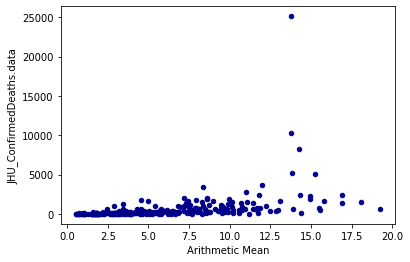

In [65]:
 ax1 = deaths_to_no2.plot.scatter(y='JHU_ConfirmedDeaths.data',
                       x='Arithmetic Mean',
                       c='DarkBlue')

In [66]:
deaths_to_no2[deaths_to_no2['JHU_ConfirmedDeaths.data'] > 20000]

,JHU_ConfirmedDeaths.data,Arithmetic Mean,LND110210
county,,,
Queens_NewYork_UnitedStates,25124.0,13.742246,NaN


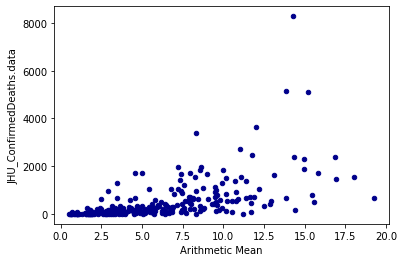

In [63]:
 
ax1 = deaths_to_no2[deaths_to_no2['JHU_ConfirmedDeaths.data'] < 10000].plot.scatter(y='JHU_ConfirmedDeaths.data',
                       x='Arithmetic Mean',
                       c='DarkBlue')

#### Average Density to Deaths

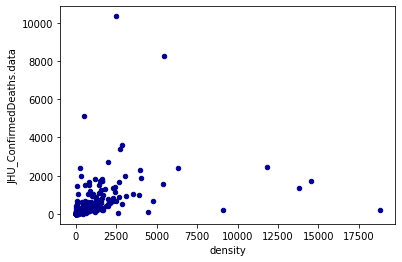

In [77]:
ax1 = deaths_to_no2.plot.scatter(y='JHU_ConfirmedDeaths.data',
                       x='density',
                       c='DarkBlue')

In [78]:
deaths_to_no2[deaths_to_no2['density'] > 17500]

,JHU_ConfirmedDeaths.data,Arithmetic Mean,density
county,,,
SanFrancisco_California_UnitedStates,186.0,8.724803,18808.384894


In [80]:
deaths_to_no2.sort_values(by='density', ascending=False)

,JHU_ConfirmedDeaths.data,Arithmetic Mean,density
county,,,
SanFrancisco_California_UnitedStates,186.0,8.724803,18808.384894
Hudson_NewJersey_UnitedStates,1699.0,15.813313,14557.068630
Suffolk_Massachusetts_UnitedStates,1374.0,10.706350,13824.711952
Philadelphia_Pennsylvania_UnitedStates,2450.0,11.788048,11812.557793
Arlington_Virginia_UnitedStates,181.0,7.452275,9119.830574
...,...,...,...
St.Joseph_Indiana_UnitedStates,347.0,4.708785,NaN
St.LouisCity_Missouri_UnitedStates,109.0,9.540296,NaN
St.Louis_Minnesota_UnitedStates,205.0,4.855522,NaN


In [82]:
sdf[sdf.county == 'SanFrancisco_California_UnitedStates']

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,...,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,county,Date Local,Arithmetic Mean,1st Max Value,AQI,density
54226,2020-01-01,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-01,10.273913,23.6,22,18808.384894
54227,2020-01-02,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-02,23.531818,35.5,33,18808.384894
54228,2020-01-03,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-03,23.317391,36.6,34,18808.384894
54229,2020-01-04,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-04,12.230435,24.6,23,18808.384894
54230,2020-01-05,0.0,0,0.0,100,0.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-01-05,10.656522,23.3,22,18808.384894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54587,2020-12-27,22319.0,0,22322.0,0,182.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-27,12.717391,20.4,19,18808.384894
54588,2020-12-28,22514.0,0,22517.0,0,182.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-28,10.404348,25.5,24,18808.384894
54589,2020-12-29,22726.0,0,22729.0,0,182.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-29,19.439130,26.1,25,18808.384894
54590,2020-12-30,22996.0,0,22999.0,0,184.0,0,0.0,100,0.0,...,2860.0,881549.0,6075,46.87,SanFrancisco_California_UnitedStates,2020-12-30,12.160870,25.3,24,18808.384894


In [143]:
sdf.corr()

,JHU_ConfirmedCases.data,JHU_ConfirmedCases.missing,NYT_ConfirmedCases.data,NYT_ConfirmedCases.missing,JHU_ConfirmedDeaths.data,JHU_ConfirmedDeaths.missing,JHU_ConfirmedRecoveries.data,JHU_ConfirmedRecoveries.missing,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Expected_Deaths_AllCauses.missing,NYT_ConfirmedDeaths.data,NYT_ConfirmedDeaths.missing,NYT_AllCausesDeathsWeekly_Excess_Deaths.data,NYT_AllCausesDeathsWeekly_Excess_Deaths.missing,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.data,NYT_AllCausesDeathsWeekly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Deaths_AllCauses.missing,NYT_AllCausesDeathsMonthly_Excess_Deaths.data,NYT_AllCausesDeathsMonthly_Excess_Deaths.missing,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.data,NYT_AllCausesDeathsMonthly_Expected_Deaths_AllCauses.missing,TotalPopulation.data,TotalPopulation.missing,MaleAndFemale_AtLeast65_Population.data,MaleAndFemale_AtLeast65_Population.missing,Male_Total_Population.data,Male_Total_Population.missing,Female_Total_Population.data,Female_Total_Population.missing,MaleAndFemale_Under18_Population.data,MaleAndFemale_Under18_Population.missing,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,fips,LND110210,Arithmetic Mean,1st Max Value,AQI
JHU_ConfirmedCases.data,1.000000,-0.030828,0.987374,-0.159080,0.641201,-0.029642,NaN,NaN,NaN,NaN,0.844167,-0.159080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.606337,-0.022154,0.597722,-0.022154,0.605484,-0.022154,0.607199,-0.022154,0.606109,-0.022154,0.596742,-0.008399,0.547618,-0.008399,0.084546,-0.008399,0.601502,-0.008399,0.055461,NaN,0.013297,-0.000813,-0.060207,NaN,0.058915,-0.000813,0.003523,-0.000813,0.000726,-0.000813,-0.025748,NaN,-0.038246,NaN,0.572557,0.593405,0.587426,0.607345,-0.115426,0.105872,0.299513,0.337964,0.338831
JHU_ConfirmedCases.missing,-0.030828,1.000000,-0.030636,0.171841,-0.026500,0.961532,NaN,NaN,NaN,NaN,-0.033640,0.171841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023138,-0.012922,-0.023150,-0.012922,-0.023276,-0.012922,-0.022323,-0.012922,-0.022575,-0.012922,-0.024313,-0.014086,-0.031334,-0.014086,-0.080017,-0.014086,-0.025610,-0.014086,-0.139268,NaN,-0.115255,-0.008935,0.017594,NaN,-0.084418,-0.008935,-0.007505,-0.008935,-0.010967,-0.008935,-0.010503,NaN,-0.018798,NaN,-0.043656,-0.047011,-0.046969,-0.024361,0.065011,0.038189,0.021145,0.012125,0.012369
NYT_ConfirmedCases.data,0.987374,-0.030636,1.000000,-0.177651,0.586641,-0.029457,NaN,NaN,NaN,NaN,0.854470,-0.177651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600806,-0.022315,0.590735,-0.022315,0.600141,-0.022315,0.601135,-0.022315,0.601486,-0.022315,0.593233,-0.012548,0.539333,-0.012548,0.072892,-0.012548,0.597346,-0.012548,0.057034,NaN,0.011819,-0.000138,-0.064620,NaN,0.054845,-0.000138,0.002215,-0.000138,-0.000878,-0.000138,-0.029526,NaN,-0.043647,NaN,0.571782,0.592082,0.586384,0.601803,-0.116538,0.105004,0.291163,0.333138,0.334051
NYT_ConfirmedCases.missing,-0.159080,0.171841,-0.177651,1.000000,-0.069344,0.165183,NaN,NaN,NaN,NaN,-0.195074,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.044462,0.034373,-0.044101,0.034373,-0.044823,0.034373,-0.043200,0.034373,-0.043784,0.034373,-0.032432,0.022882,-0.116696,0.022882,-0.368729,0.022882,-0.04331

In [145]:
deaths_to_no2.corr()

,JHU_ConfirmedDeaths.data,Arithmetic Mean,density
JHU_ConfirmedDeaths.data,1.000000,0.395541,0.326072
Arithmetic Mean,0.395541,1.000000,0.424515
density,0.326072,0.424515,1.000000


In [1]:
deaths_to_no2[:5]

NameError: name 'deaths_to_no2' is not defined

In [74]:
a = [1,2,3]
[0] + a

[0, 1, 2, 3]